In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yaml
import torch
import torchvision
import os

In [2]:
from torchvision.transforms.v2 import Resize, Normalize

data = []
for filename in os.listdir("images/"):
    f = os.path.join("images/", filename)
    img = torchvision.io.read_image(f)
    res = Resize((64,64))
    img = res(Normalize(img.type(torch.float32).mean([1,2]),img.type(torch.float32).std([1,2]))(img.type(torch.float32)))
    if "Catharanthus" in filename:
        data.append((img,0))
    if "Mirabilis" in filename:
        data.append((img,1))
    if "Tecoma" in filename:
        data.append((img,2))

c:\Users\egn\Documents\projects\py\pytorch_lrn\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [3]:
label_dict = {"0":"Tecoma stans","1":"Mirabilis jalapa","2":"Catharanthus roseus"}

In [4]:
target = np.array([x[1] for x in data])
data_img = [x[0] for x in data]

In [5]:
from datasets import ImageDataset

dataset = ImageDataset(data_img, torch.tensor(target).reshape(-1,1).type(torch.float32))

dataset_train, dataset_test = torch.utils.data.random_split(dataset,[0.7,0.3])

In [6]:
from models import CNN
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=1000, out_features=512, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
  (relu5): ReLU()
  (lin3): Linear(in_features=256, out_features=100, bias=True)
  (lin4): Linear(in_features=100, out_features=3, bias=True)
)


In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.5)
loss_function = torch.nn.CrossEntropyLoss()

x = []
y = []

def train_loop(epochs, dataloader:torch.utils.data.DataLoader):
    model.train()
    for epoch in range(epochs):
        ab_loss = 0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            logits = model(inputs)
            loss = loss_function(logits, labels.type(torch.int64).reshape(-1))
            loss.backward()
            optimizer.step()
            ab_loss += loss
        x.append(ab_loss.item())
        y.append(epoch)
        if epoch % 10 == 0:
            print(ab_loss)
    model.eval()
    return(x,y)

In [8]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset=dataset_train, batch_size=100, shuffle=True)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=True)

train_loop(100, dataloader)
print()

tensor(12.0768, grad_fn=<AddBackward0>)
tensor(11.8834, grad_fn=<AddBackward0>)
tensor(10.5376, grad_fn=<AddBackward0>)
tensor(7.7352, grad_fn=<AddBackward0>)
tensor(7.5641, grad_fn=<AddBackward0>)
tensor(6.7945, grad_fn=<AddBackward0>)
tensor(6.2015, grad_fn=<AddBackward0>)
tensor(5.8088, grad_fn=<AddBackward0>)
tensor(5.0215, grad_fn=<AddBackward0>)
tensor(4.2417, grad_fn=<AddBackward0>)



Text(0.5, 0, 'epoch')

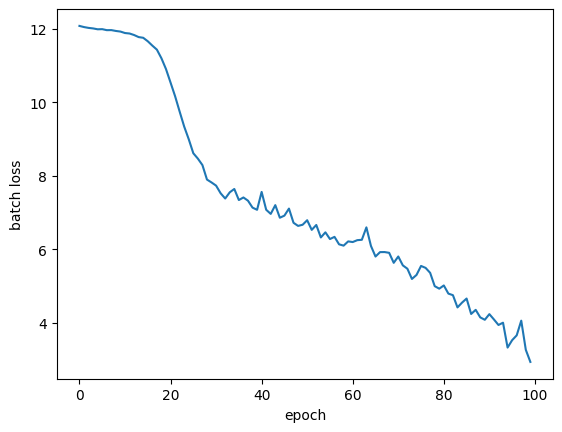

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.array(y),np.array(x))
plt.ylabel("batch loss")
plt.xlabel("epoch")

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader_test:
        images, labels = data
        labels = labels.type(torch.int64).reshape(-1)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the my model on the {total} test images: {100 * correct / total} %')

Accuracy of the my model on the 445 test images: 72.80898876404494 %


 \
Хороший результат при использовании довольно простой модели (100 эпох за 1.5 минуты на cpu) и наличии в датасете сложных \
![Tecoma stans_515.png](<attachment:Tecoma stans_515.png>) \
 изображений где вид цветка приходится определять по виду листьев, для чего модели нужно значительное количество слоев с шаблонами.
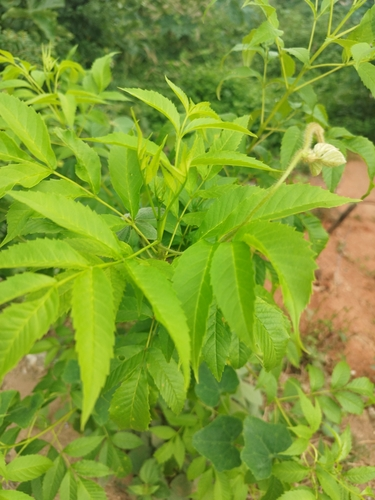